In [1]:
runname = "MagsColorsTrueCS"

PPRpredsuse = ['rband Mag','gband Mag','iband Mag','zband Mag','g - r','r - i','i - z','central_bool']

NNpredsuse = PPRpredsuse

predsscl = ['rband Mag','gband Mag','iband Mag','zband Mag','g - r','r - i','i - z']

In [2]:
# This controls the number of projection functions in the PPR
ruse = 5

traintestseed = 1

epochs=500

learning_rate = 0.001

decay_rate = learning_rate / epochs

momentum = 0.8

# Import Packages

In [3]:
%pylab inline

import illustris_python as il
import pandas as pd
import pickle

import os

from astropy.table import Table

from matplotlib.colors import LogNorm

from sklearn.model_selection import train_test_split

from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [4]:
basePath= '/hildafs/datasets/IllustrisTNG/TNG100-1/output'
snapNum=99 #refers to final snapshot, redshift of zero

# Create the combined catalog

Start with data from the base Illustris catalog.

See https://www.tng-project.org/data/docs/specifications/#sec2b

These are the fields that will be extracted from this catalog.

In [5]:
addvariables = ['SubhaloBHMass','SubhaloGasMetallicity','SubhaloSFR',
                'SubhaloStarMetallicity','SubhaloVmax']

In [6]:
fields = ['SubhaloGrNr',
          'SubhaloFlag',
          'SubhaloMassType',
          'SubhaloPos',
          'SubhaloStellarPhotometrics',
          'SubhaloMassInHalfRad',
          'SubhaloHalfmassRad',
          'SubhaloHalfmassRadType'] + addvariables

In [7]:
subhalos=il.groupcat.loadSubhalos(basePath,snapNum,fields=fields)

This is here just for reference:

0. PartType0 - GAS
1. PartType1 - DM
2. PartType2 - (unused)
3. PartType3 - TRACERS
4. PartType4 - STARS & WIND PARTICLES
5. PartType5 - BLACK HOLES

### Read in additional catalogs

THIS SEEMS TO BE UNNECESSARY. EVERYTHING IN HERE APPEARS TO BE IN THE FULL CATALOG BELOW.
The shape catalog. Note that this catalog already comes in with a mass cut of `10**10 M_sun`.

In [8]:
#df_non_red_100_subfind_shapes = pd.DataFrame(
#    pickle.load(open('/hildafs/datasets/IllustrisTNG/TNG100-1/df_non_red_100_subfind_mass-cut10', "rb" ) ))
#df_non_red_100_subfind_shapes.shape

The velocity dispersion catalog.

In [9]:
df_non_red_100_subfind_sigma_v = pd.DataFrame(pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_vel_disp_100.0.p', 
         "rb" ) ))

print(df_non_red_100_subfind_sigma_v.shape)
df_non_red_100_subfind_sigma_v.head()

(20051, 5)


,gal_id,Lx,Ly,Lz,sigma_v
0,0.0,-9.085662,-7.872045,-4.559502,374.378662
1,1.0,1.795185,-0.857926,1.563985,214.005508
2,2.0,0.620052,2.585010,0.742175,196.719849
3,3.0,0.292968,-0.387597,-1.368885,106.750359
4,4.0,-0.058817,0.112009,-0.858557,116.125282


Density information. *This was removed because the code to generate the density information was added below.*

In [10]:
# galdens = pickle.load(open('galdens.p', 'rb'))

The "full" catalog.

In [11]:
df_non_red_100_subfind_full = pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_component_shapes_3I_subfind_FULL_mass-cut9.p', 
         "rb" ) )

print(df_non_red_100_subfind_full.shape)
df_non_red_100_subfind_full.head()

(20051, 114)


,gal_id,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,...,bv_z,cv_x,cv_y,cv_z,mass,gal_pos_x,gal_pos_y,gal_pos_z,e1,e2
0,0.0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,...,0.377225,0.782535,0.612006,0.114402,3.705585e+12,0.849091,26.326996,18.306934,-0.109703,-0.157248
1,1.0,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,...,0.469768,-0.159400,0.476258,-0.864737,5.587917e+11,0.106473,24.633322,16.900553,0.295580,0.009956
2,2.0,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,...,-0.293690,0.135702,0.904910,0.403390,6.271396e+11,0.853112,26.725748,17.510679,0.026402,-0.016790
3,3.0,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,...,-0.012360,-0.111798,0.556926,0.823003,1.715515e+11,0.245455,26.517372,15.888749,-0.066341,-0.033003
4,4.0,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,...,0.015853,-0.002944,-0.163988,0.986458,1.333404e+11,0.768784,26.518290,15.530523,-0.028562,0.007162


Note that, for some reason, `gal_id` appears twice in the "full" catalog. Hence, the `drop` function removes both of those instances. It's for this reason that I am dropping from the "full" catalog, and not from the velocity dispersion catalog.

In [13]:
fullinfo = pd.concat(
    [df_non_red_100_subfind_full.drop({'gal_id'},axis=1),
     df_non_red_100_subfind_sigma_v], 
     axis=1)

### Create the merged catalog

For each variable in the base catalog, need to extract the elements based on `gal_id` in the supplemental catalog.

The photometric magnitudes.

In [14]:
fullinfo['gband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),4]
fullinfo['rband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),5]
fullinfo['iband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),6]
fullinfo['zband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),7]

Colors

In [15]:
fullinfo['g - r'] = fullinfo['gband Mag'] - fullinfo['rband Mag']
fullinfo['r - i'] = fullinfo['rband Mag'] - fullinfo['iband Mag']
fullinfo['i - z'] = fullinfo['iband Mag'] - fullinfo['zband Mag']

Size and mass. (Mass measures stars.)

In [16]:
fullinfo['size'] = subhalos['SubhaloHalfmassRad'][fullinfo['gal_id'].astype('int')]
fullinfo['galaxy_mass'] = \
     subhalos['SubhaloMassType'][fullinfo['gal_id'].astype('int'),4]*10**10

Other variables from the base catalog.

In [17]:
for addvar in addvariables:
    fullinfo[addvar] = subhalos[addvar][fullinfo['gal_id'].astype('int')]

The subhalo flag is mapped over, in order to exclude flagged observations.

In [18]:
fullinfo['subhaloflag'] = subhalos['SubhaloFlag'][fullinfo['gal_id'].astype('int')]

There are some duplicated columns. Note that the data in them were not actually identical. In particular, the position variables were off by a factor of 1000. See below for reintroduction of these columns, in different units.

In [19]:
fullinfo = fullinfo.loc[:,~fullinfo.columns.duplicated()]

## Generate the density information

Define x,y,z columns for cordinates. We will use the names x,y,z, below, instead of gal_pos_x etc.
We will also use units of Mpc instead of Kpc, hence division by 1000

In [20]:
fullinfo['x']=float64(fullinfo['gal_pos_x']/1000)
fullinfo['y']=float64(fullinfo['gal_pos_y']/1000)
fullinfo['z']=float64(fullinfo['gal_pos_z']/1000)

Generate the 2D density information

<ipython-input-21-7f7314c8a267>:27: RuntimeWarning: divide by zero encountered in true_divide
  potential_smooth_F=delta_smooth_F/k2#fourier space potential
<ipython-input-21-7f7314c8a267>:27: RuntimeWarning: invalid value encountered in true_divide
  potential_smooth_F=delta_smooth_F/k2#fourier space potential
<ipython-input-21-7f7314c8a267>:29: RuntimeWarning: invalid value encountered in true_divide
  tidal1_F=delta_smooth_F*(k[:,None]**2-k[None,:]**2)/k2 #fourier space tidal field
<ipython-input-21-7f7314c8a267>:30: RuntimeWarning: invalid value encountered in true_divide
  tidal2_F=delta_smooth_F*(k[:,None]*k[None,:])/k2


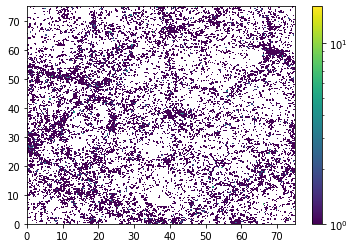

In [21]:
nbins=1000 #this determines the grid resolution. resolution per side = 75/nbins in mpc/h.
be=np.linspace(0,75,nbins+1)
bc=0.5*(be[1:]+be[:-1])

galaxy_counts,ye,xe=np.histogram2d(fullinfo['x'],fullinfo['y'],bins=(be,be))

cc2,xe2,ye2,_=hist2d(fullinfo['x'],fullinfo['y'],bins=(be,be),norm=LogNorm())

pcolor(bc,bc,galaxy_counts.T,norm=LogNorm())
colorbar()

k=np.fft.fftfreq(nbins, d=be[1]-be[0]) #fourier modes
k2=(k[:,None]**2+k[None,:]**2) #square of fourier modes

delta_R=galaxy_counts/galaxy_counts.mean()-1 #real space density field
delta_F=np.fft.fft2(delta_R)#fourier space density field

#apply gaussian smoothing kernel
smooth_r=1 #smoothing scale, in mpc/h
smooth_F=2*np.pi/smooth_r

smooth_filter=np.exp(-k2/(2*smooth_F**2))

delta_smooth_F=delta_F*smooth_filter
delta_smooth_R=np.fft.ifft2(delta_smooth_F)

potential_smooth_F=delta_smooth_F/k2#fourier space potential

tidal1_F=delta_smooth_F*(k[:,None]**2-k[None,:]**2)/k2 #fourier space tidal field
tidal2_F=delta_smooth_F*(k[:,None]*k[None,:])/k2

tidal1_F[np.where(k2==0)]=0 #correct for divide by 0
tidal2_F[np.where(k2==0)]=0
potential_smooth_F[np.where(k2.T==0)]=0

tidal1_R=np.fft.ifft2(tidal1_F) # real space tidal field
tidal2_R=np.fft.ifft2(tidal2_F)
potential_smooth_R=np.fft.ifft2(potential_smooth_F)


#find indices of grid cells to which galaxies belong
bi={}
for coor in ['x','y']:
    bi[coor]=np.digitize(fullinfo[coor],bins=be)-1
    

    
#assign 2d density field to galaxies.
galaxies_delta_smooth_R=delta_smooth_R[bi['x'],bi['y']]

#assign 2d tidal field to galaxies.
galaxies_tidal1_R=tidal1_R[bi['x'],bi['y']]
galaxies_tidal2_R=tidal2_R[bi['x'],bi['y']]

fullinfo['delta_smooth_R'] = np.real(galaxies_delta_smooth_R)
fullinfo['tidal1_R'] = np.real(galaxies_tidal1_R)
fullinfo['tidal2_R'] = np.real(galaxies_tidal2_R)

Generate the 3D density information

In [ ]:
nbins=750#//2 #this determines the grid resolution. resolution per side = 75/nbins in mpc/h.
be=np.linspace(0,75,nbins+1)
bc=0.5*(be[1:]+be[:-1])

galaxy_counts3d,be3=np.histogramdd(np.array([fullinfo['x'],fullinfo['y'],fullinfo['z']]).T,bins=[be,be,be])

In [144]:
k=np.fft.fftfreq(nbins, d=be[1]-be[0]) #fourier modes
k2=(k[:,None,None]**2+k[None,:,None]**2+k[None,None,:]**2) #square of fourier modes

delta3d_R=galaxy_counts3d/galaxy_counts3d.mean()-1 #real space density field
delta3d_F=np.fft.fftn(delta3d_R)#fourier space density field

#apply gaussian smoothing kernel
smooth_r=1 #smoothing scale, in mpc/h
smooth_k=2*np.pi/smooth_r

smooth_filter=np.exp(-k2/(2*smooth_k**2))

delta3d_smooth_F=delta3d_F#*smooth_filter
delta3d_smooth_R=np.fft.ifftn(delta3d_smooth_F)

potential3d_smooth_F=delta3d_smooth_F/k2

tidal1_3d_F=delta3d_smooth_F*(k[:,None,None]**2-k[None,:,None]**2)/k2
tidal2_3d_F=delta3d_smooth_F*(k[:,None,None]*k[None,:,None])/k2

tidal1_3d_F[np.where(k2==0)]=0
tidal2_3d_F[np.where(k2==0)]=0
potential3d_smooth_F[np.where(k2.T==0)]=0

tidal1_3d_R=np.fft.ifftn(tidal1_3d_F)
tidal2_3d_R=np.fft.ifftn(tidal2_3d_F)
potential3d_smooth_R=np.fft.ifftn(potential3d_smooth_F)

#find indices of grid cells to which galaxies belong
bi={}
for coor in ['x','y','z']:
    bi[coor]=np.digitize(fullinfo[coor],bins=be)-1
    
#assign 3d density to galaxies.
galaxies_delta3d_smooth_R=delta3d_smooth_R[bi['x'],bi['y'],bi['z']]

#assign 3d tidal field to galaxies.
galaxies_tidal1_3d_R=tidal1_3d_R[bi['x'],bi['y'],bi['z']]
galaxies_tidal2_3d_R=tidal2_3d_R[bi['x'],bi['y'],bi['z']]

fullinfo['delta_smooth_3D'] = np.real(galaxies_delta3d_smooth_R)
fullinfo['tidal1_3D'] = np.real(galaxies_tidal1_3d_R)
fullinfo['tidal2_3D'] = np.real(galaxies_tidal2_3d_R)
#fullinfo['delta_smooth_imag'] = np.imag(galaxies_delta3d_smooth_R)

<ipython-input-144-c5aefd249bcb>:16: RuntimeWarning: divide by zero encountered in true_divide
  potential3d_smooth_F=delta3d_smooth_F/k2
<ipython-input-144-c5aefd249bcb>:16: RuntimeWarning: invalid value encountered in true_divide
  potential3d_smooth_F=delta3d_smooth_F/k2
<ipython-input-144-c5aefd249bcb>:18: RuntimeWarning: invalid value encountered in true_divide
  tidal1_3d_F=delta3d_smooth_F*(k[:,None,None]**2-k[None,:,None]**2)/k2
<ipython-input-144-c5aefd249bcb>:19: RuntimeWarning: invalid value encountered in true_divide
  tidal2_3d_F=delta3d_smooth_F*(k[:,None,None]*k[None,:,None])/k2


## Filter Observations

Exclude any observations for which the `SubhaloFlag` is `False` or the mass is not sufficiently large. If mass cutoff is $10^9$, there should be 17513 rows remaining. If the mass cutoff is $10^{10}$, there should be 4987 rows remaining.

In [24]:
keep = (fullinfo['subhaloflag']) & (fullinfo['galaxy_mass'] > 10**9) 
print(sum(keep))

subinfo = fullinfo[keep].copy()

17513


Create log-transformed versions of some variables.

In [25]:
varsToLogTransform = ['galaxy_mass',
                      'sigma_v',
                      'size']

for varname in varsToLogTransform:
    subinfo['log ' + varname] = log10(subinfo[varname])

Some of the variables have a spike of values at zero, but are otherwise positive (and skewed). The strategy taken here is to create an indicator variable for zero values, and then log transform the positive values. Hence, there are two variables included in the model for each of these.

In [26]:
# SubhaloBHMassZero

subinfo['SubhaloBHMassZero'] = (subinfo['SubhaloBHMass'] == 0).astype(int)

subinfo['log SubhaloBHMass'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloBHMass']]


# SubhaloSFR

subinfo['SubhaloSFRZero'] = (subinfo['SubhaloSFR'] == 0).astype(int)

subinfo['log SubhaloSFR'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloSFR']]


# SubhaloGasMetallicity is not skewed

subinfo['SubhaloGasMetallicityZero'] = (subinfo['SubhaloGasMetallicity'] == 0).astype(int)


Create indicators for the different size bins.

In [27]:
holdQ = pd.qcut(subinfo['log size'],4,labels=["SizeQ1","SizeQ2","SizeQ3","SizeQ4"])

subinfo['SizeQ1'] = (holdQ == "SizeQ1").astype(int)
subinfo['SizeQ2'] = (holdQ == "SizeQ2").astype(int)
subinfo['SizeQ3'] = (holdQ == "SizeQ3").astype(int)
subinfo['SizeQ4'] = (holdQ == "SizeQ4").astype(int)

subinfo['small sigma_v'] = (subinfo['log sigma_v'] <-2).astype(int)

#subinfo = subinfo[subinfo['SizeQ4']==1]

## Visualization of relationships

In [39]:
import seaborn as sns

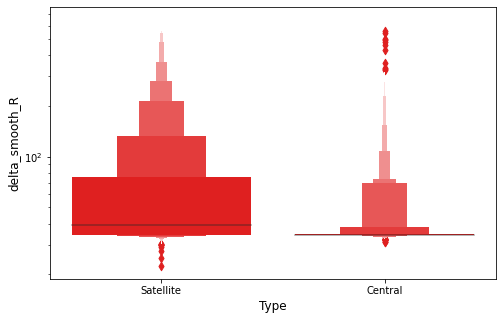

In [56]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="delta_smooth_R", 
    data=subinfo,color="red")
ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("delta_smooth_R",size=12)
plt.show()

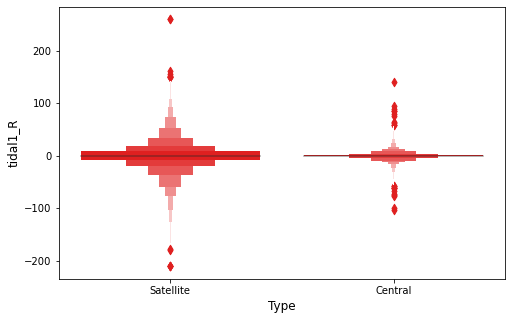

In [52]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="tidal1_R", 
    data=subinfo,color="red")
#ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("tidal1_R",size=12)
plt.show()

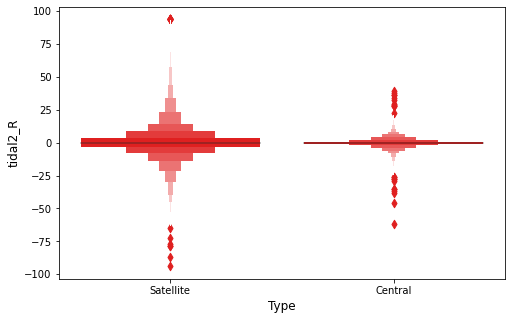

In [53]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="tidal2_R", 
    data=subinfo,color="red")
#ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("tidal2_R",size=12)
plt.show()

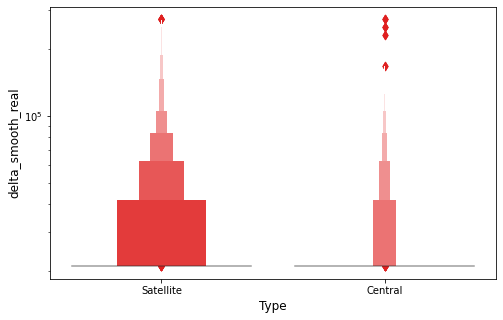

In [88]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="delta_smooth_real", 
    data=subinfo,color="red")
ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("delta_smooth_real",size=12)
plt.show()

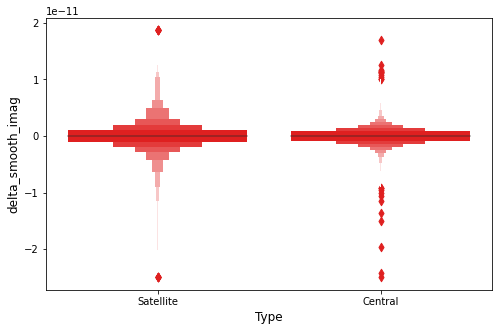

In [66]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="delta_smooth_imag", 
    data=subinfo,color="red")
#ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("delta_smooth_imag",size=12)
plt.show()

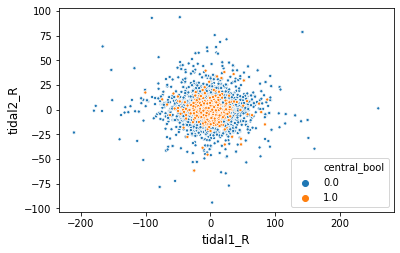

In [92]:
plt.figure(figsize=[6,3.75])
ax = sns.scatterplot(x="tidal1_R", y="tidal2_R",
    data=subinfo, s=10,hue="central_bool")
#ax.set(xscale="log", yscale="log")
plt.xlabel("tidal1_R", size=12)
plt.ylabel("tidal2_R", size=12)
plt.show()

Add variable that is distance from origin.

In [93]:
subinfo['2dDensDist'] = subinfo['tidal1_R']**2 + subinfo['tidal2_R']**2

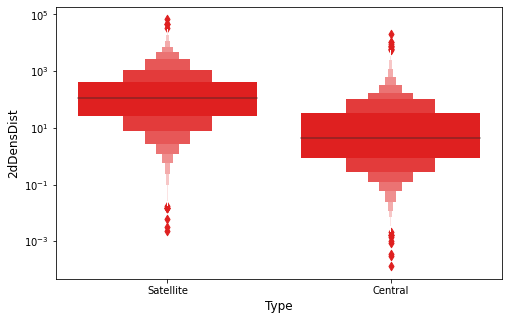

In [94]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="2dDensDist", 
    data=subinfo,color="red")
ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("2dDensDist",size=12)
plt.show()

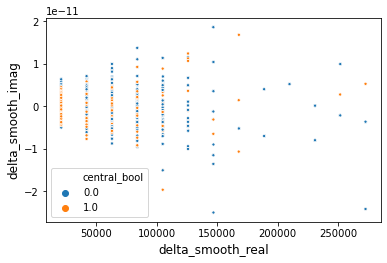

In [95]:
plt.figure(figsize=[6,3.75])
ax = sns.scatterplot(x="delta_smooth_real", y="delta_smooth_imag",
    data=subinfo, s=10,hue="central_bool")
#ax.set(xscale="log", yscale="log")
plt.xlabel("delta_smooth_real", size=12)
plt.ylabel("delta_smooth_imag", size=12)
plt.show()

## Fit models for central/satellite split

What proportion are central galaxies (and not satellites)?

In [96]:
round(sum(subinfo['central_bool'])/len(subinfo['central_bool']),3)

0.583

In [128]:
CSpredsuse = ['rband Mag','gband Mag','iband Mag','zband Mag',
              'delta_smooth_R','tidal1_R','tidal2_R']

CSpredsuse = ['rband Mag','gband Mag','iband Mag','zband Mag','2dDensDist','delta_smooth_R']

CSrespuse = 'central_bool'

Split into test and training set. Note that in this case, the test set will serve as the full data set in the later analysis. In other words, a portion of the data set (the training set here) is set aside for the purpose of fitting the CS model. We will then make the predictions on the remaining set (the test set here). That test set will be used in the later analysis.

It is for this reason that the test set size is going to be chosen larger than one would normally do so.

In [129]:
train_features, test_features, train_labels, test_labels = \
   train_test_split(subinfo[CSpredsuse], subinfo[CSrespuse], 
        test_size = 0.70, random_state = 21)

train_features = train_features.astype(float)
test_features = test_features.astype(float)

In [130]:
from tensorflow.keras import models, layers, utils, backend as K

from tensorflow.keras.optimizers import SGD

# Set up model architecture

n_features = len(CSpredsuse)

NNmodel = models.Sequential(name="SimpleNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation="sigmoid")
])

Compile the neural network

In [131]:
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

NNmodel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Now fit the model on the training set.

In [132]:
training = NNmodel.fit(x=np.asarray(train_features),
                     y=np.asarray(train_labels), 
     batch_size=32, epochs=epochs, shuffle=True, verbose=0,
    validation_split=0.3)

Performance on test and training sets.

In [133]:
NNfitsontest = np.reshape(NNmodel.predict(test_features),-1)
NNfitsontrain = np.reshape(NNmodel.predict(train_features),-1)

NNclassontrain = NNfitsontrain > 0.5
NNclassontest = NNfitsontest > 0.5

print("On the training set:")
print(metrics.confusion_matrix(train_labels, NNclassontrain))

print("\nOn the test set:")
print(metrics.confusion_matrix(test_labels, NNclassontest))

On the training set:
[[1650  515]
 [ 716 2372]]

On the test set:
[[3890 1252]
 [1565 5553]]


In [134]:
dftest = pd.DataFrame({'NNfitsontest': NNfitsontest,'central_bool': test_labels})

dftrain = pd.DataFrame({'NNfitsontrain': NNfitsontrain,
        'central_bool': train_labels})

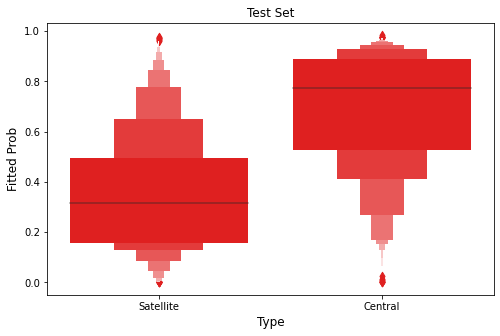

In [139]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="NNfitsontest", 
    data=dftest,color="red")
#ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("Fitted Prob",size=12)
plt.title("Test Set")
plt.show()

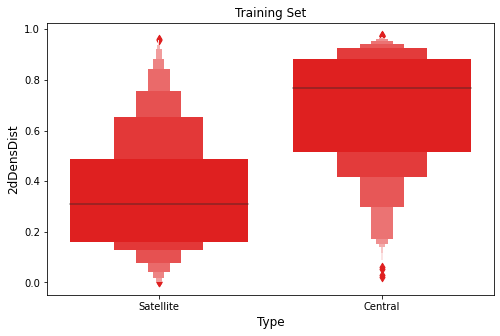

In [136]:
plt.figure(figsize=[8,5])
ax = sns.boxenplot(x="central_bool",
    y="NNfitsontrain", 
    data=dftrain,color="red")
#ax.set(yscale="log")
ax.set_xticklabels(['Satellite','Central'])
plt.xlabel("Type",size=12)
plt.ylabel("2dDensDist",size=12)
plt.title("Training Set")
plt.show()

Get predictions on the entire set. Keep in mind that, ultimately, only the test set should be used in further analyses.

In [137]:
holdpreds = subinfo[CSpredsuse].astype(float)

holdfits = np.reshape(NNmodel.predict(holdpreds),-1)

Write to file.

In [138]:
import pickle
f = open("CSpredsbyNN.p",'wb')
pickle.dump(holdfits, f) #call with (object, file)
f.close()

In [38]:
THIS IS HERE SPECIFICALLY TO MAKE IT CRASH

SyntaxError: invalid syntax (<ipython-input-38-26a4791047b3>, line 1)

In [ ]:
from tensorflow.keras import models, layers, utils, backend as K

from tensorflow.keras.optimizers import SGD

# Set up model architecture

n_features = len(CSpredsuse)

NNfullmodel = models.Sequential(name="SimpleNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation="sigmoid")
])

NNfullmodel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

holdpreds = subinfo[CSpredsuse].astype(float)
trainingfull = NNfullmodel.fit(x=np.asarray(holdpreds),
                               y=np.asarray(subinfo[CSrespuse]), 
     batch_size=32, epochs=epochs, shuffle=True, verbose=0,
    validation_split=0.3)
    
holdfits = np.reshape(NNfullmodel.predict(holdpreds),-1)

In [ ]:
holdfits

In [ ]:
import pickle
f = open("CSpredsbyNN.p",'wb')
pickle.dump(holdfits, f) #call with (object, file)
f.close()

In [ ]:
this is specifically here to make the code crash

## Set the predictors and response

In [ ]:
respuse = 'central_bool'

The predictors are now set at the top of the file.

In [ ]:
predsuse = ['log galaxy_mass','log sigma_v','rband Mag','gband Mag','iband Mag',
            'zband Mag', 'g - r','r - i','i - z',
            'log SubhaloSFR', 'SubhaloSFRZero','mc_disk','small sigma_v']

predsuse = ['rband Mag','gband Mag','iband Mag','zband Mag','g - r','r - i','i - z']

CSpredsuse = ['rband Mag','gband Mag','iband Mag','zband Mag']
CSrespuse = 'central_bool'

#predsscl = ['rband Mag','gband Mag','iband Mag','zband Mag','g - r','r - i','i - z']

## Scale Selected Predictors

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(copy=True)

scaler.fit(subinfo[predsscl])

foo = pd.DataFrame(scaler.transform(subinfo[predsscl]),columns=predsscl, index=subinfo.index)

subinfo = pd.DataFrame.join(subinfo.drop(predsscl,axis=1),foo)

In [ ]:
subinfo.head()

## Split into Test and Training Sets

In [ ]:
train_features, test_features, train_labels, test_labels = \
   train_test_split(subinfo[predsuse], subinfo[respuse], 
        test_size = 0.7, random_state = traintestseed)

train_features = train_features.astype(float)
test_features = test_features.astype(float)

## Random Forest

Some of the syntax is taken from 
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Instantiate model with `numtrees` decision trees

In [ ]:
numtrees = 10

In [ ]:
rf = RandomForestClassifier(n_estimators = numtrees, random_state = 0)

Train the model on training data

In [ ]:
rf.fit(train_features, train_labels);

Predict on the training and test sets

In [ ]:
RFfitsontest = rf.predict(test_features)
RFfitsontrain = rf.predict(train_features)

In [ ]:
from sklearn import metrics

print("On the training set:")
print(metrics.confusion_matrix(train_labels, RFfitsontrain))

print("\nOn the test set:")
print(metrics.confusion_matrix(test_labels, RFfitsontest))

## Tuning parameter selection for Random forest

Some of this code is adapated (stolen) from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


# Neural Network

Some of this syntax is based on https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

In [ ]:
from tensorflow.keras import models, layers, utils, backend as K

from tensorflow.keras.optimizers import SGD


# Set up model architecture

n_features = len(predsuse)

model = models.Sequential(name="SimpleNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=200, 
                 activation='relu'),
    
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation="sigmoid")
])

Compile the neural network

In [ ]:
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
training = model.fit(x=np.asarray(train_features),
                     y=np.asarray(train_labels), 
     batch_size=32, epochs=epochs, shuffle=True, verbose=0,
    validation_split=0.3)

In [ ]:
NNfitsontest = np.reshape(model.predict(test_features),-1)
NNfitsontrain = np.reshape(model.predict(train_features),-1)

NNclassontrain = NNfitsontrain > 0.5
NNclassontest = NNfitsontest > 0.5

print("On the training set:")
print(metrics.confusion_matrix(train_labels, NNclassontrain))

print("\nOn the test set:")
print(metrics.confusion_matrix(test_labels, NNclassontest))

### Refit NN to entire data set

In [ ]:
CSpredsuse = ['rband Mag','gband Mag','iband Mag','zband Mag']
CSrespuse = 'central_bool'

from tensorflow.keras import models, layers, utils, backend as K

from tensorflow.keras.optimizers import SGD

# Set up model architecture

n_features = len(CSpredsuse)

NNfullmodel = models.Sequential(name="SimpleNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=20, 
                 activation='relu'),
    
    layers.Dropout(name="drop1", rate=0.2),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=20, 
                 activation='relu'),
    
    layers.Dropout(name="drop2", rate=0.2),
    
    ### layer output
    layers.Dense(name="output", units=1, activation="sigmoid")
])

NNfullmodel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

holdpreds = subinfo[CSpredsuse].astype(float)
trainingfull = NNfullmodel.fit(x=np.asarray(holdpreds),
                               y=np.asarray(subinfo[CSrespuse]), 
     batch_size=32, epochs=epochs, shuffle=True, verbose=0,
    validation_split=0.3)
    
holdfits = np.reshape(NNfullmodel.predict(holdpreds),-1)

import pickle
f = open("CSpredsbyNN.txt")
pickle.dump(holdfits, f) #call with (object, file)
f.close()

**OLD BELOW HERE**

In [ ]:
plt.figure(figsize=[5,5])
hist2d(x=PPRfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Projection Pursuit Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

In [ ]:
print("RMSE NN on test set:")
print(sqrt(mean((NNfitsontest-test_labels)**2)))

print("RMSE NN on training set:")
print(sqrt(mean((NNfitsontrain-train_labels)**2)))

In [ ]:
plt.figure(figsize=[5,5])
hist2d(x=NNfitsontest,
       y=test_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Neural Network Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
plt.xlim(-1.5,3)
plt.ylim(-1.5,3)

plt.show()

In [ ]:
ReportOutput()